In [2]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
    width:max-content;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output > pre {
   width:max-content;
}
</style>

In [ ]:
#import dask.array as da
#import dask.dataframe as dd

In [3]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.types import StringType, DateType
from pyspark.sql.functions import lit, year, month, dayofmonth, last_day, col, array, explode, struct, udf, to_date, month, year, percent_rank, when, lag, first, avg
from pyspark.sql.functions import sum as spark_sum, max as spark_max, min as spark_min

In [6]:
import OpSpark

In [7]:
spark = SparkSession.builder.appName('Rank_Median').getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Rank_Median>

In [8]:
#dd.read_parquet("data/master/ophelia/data/OpheliaData/analytical_base_table")

In [9]:
## por temas de replicación, siempre es mejor convertir el archivo a leer en formato csv

monthly_data_df = spark.read.parquet("data/master/ophelia/data/OpheliaData/analytical_base_table")
index_vector_csv = spark.read.csv("data/raw/csv/unique_dateprice_vector.csv", header=True, inferSchema=True)

In [10]:
from datetime import datetime

def datetime_object(datetime_str):
    print(datetime_str)
    datetime_object = datetime.strptime(datetime_str, '%d/%m/%y').date()
    return datetime_object

datetime_object_udf = udf(f=datetime_object, returnType=DateType())

In [11]:
index_vector_schema = index_vector_csv.select("MXWDU_Index", datetime_object_udf(col("operation_date")).alias('operation_date'))
index_vector_schema.show(10, False)

+-----------+--------------+
|MXWDU_Index|operation_date|
+-----------+--------------+
|51.12      |2016-01-01    |
|54.830002  |2016-01-04    |
|54.880001  |2016-01-05    |
|54.049999  |2016-01-06    |
|52.790001  |2016-01-07    |
|52.18      |2016-01-08    |
|52.240002  |2016-01-11    |
|52.580002  |2016-01-12    |
|51.509998  |2016-01-13    |
|52.259998  |2016-01-14    |
+-----------+--------------+
only showing top 10 rows



In [12]:
close_date_index = index_vector_schema.select("*", month(col("operation_date")).alias("month"), year(col("operation_date")).alias("year"))\
                                      .groupBy("year", "month").agg(spark_max("operation_date").alias("operation_date")).drop("year", "month")\
                                      .join(index_vector_schema, on="operation_date", how="left")
print(close_date_index.shape)
close_date_index.orderBy(col("operation_date").desc()).show(10, False)

(44, 2)
+--------------+-----------+
|operation_date|MXWDU_Index|
+--------------+-----------+
|2019-08-15    |70.279999  |
|2019-07-31    |73.760002  |
|2019-06-28    |73.709999  |
|2019-05-31    |70.089996  |
|2019-04-30    |74.620003  |
|2019-03-29    |72.150002  |
|2019-02-28    |71.029999  |
|2019-01-31    |69.32      |
|2018-12-31    |64.160004  |
|2018-11-30    |69.830002  |
+--------------+-----------+
only showing top 10 rows



In [13]:
index_portfolio_df = close_date_index.join(monthly_data_df, on="operation_date", how="left")
print(index_portfolio_df.shape)
index_portfolio_df.orderBy(col("operation_date")).show(10, False)

(44, 214)
+--------------+-----------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+--------+--------+--------+---------+--------+--------+--------+--------+--------+---------+--------+--------+---------+--------+--------+--------+--------+---------+--------+---------+---------+--------+---------+--------+--------+--------+--------+-------+--------+---------+--------+---------+--------+----------+--------+----------+---------+--------+----------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+----------+----------+----------+----------+--------+----------+----------+----------+----------+---------+-------

In [14]:
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [15]:
def evolved_time_frame(df):
    table = df.toPandas()
    plt.figure(figsize=(20, 10))
    for c in table.columns.values:
        plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
    plt.ylabel('price in $')

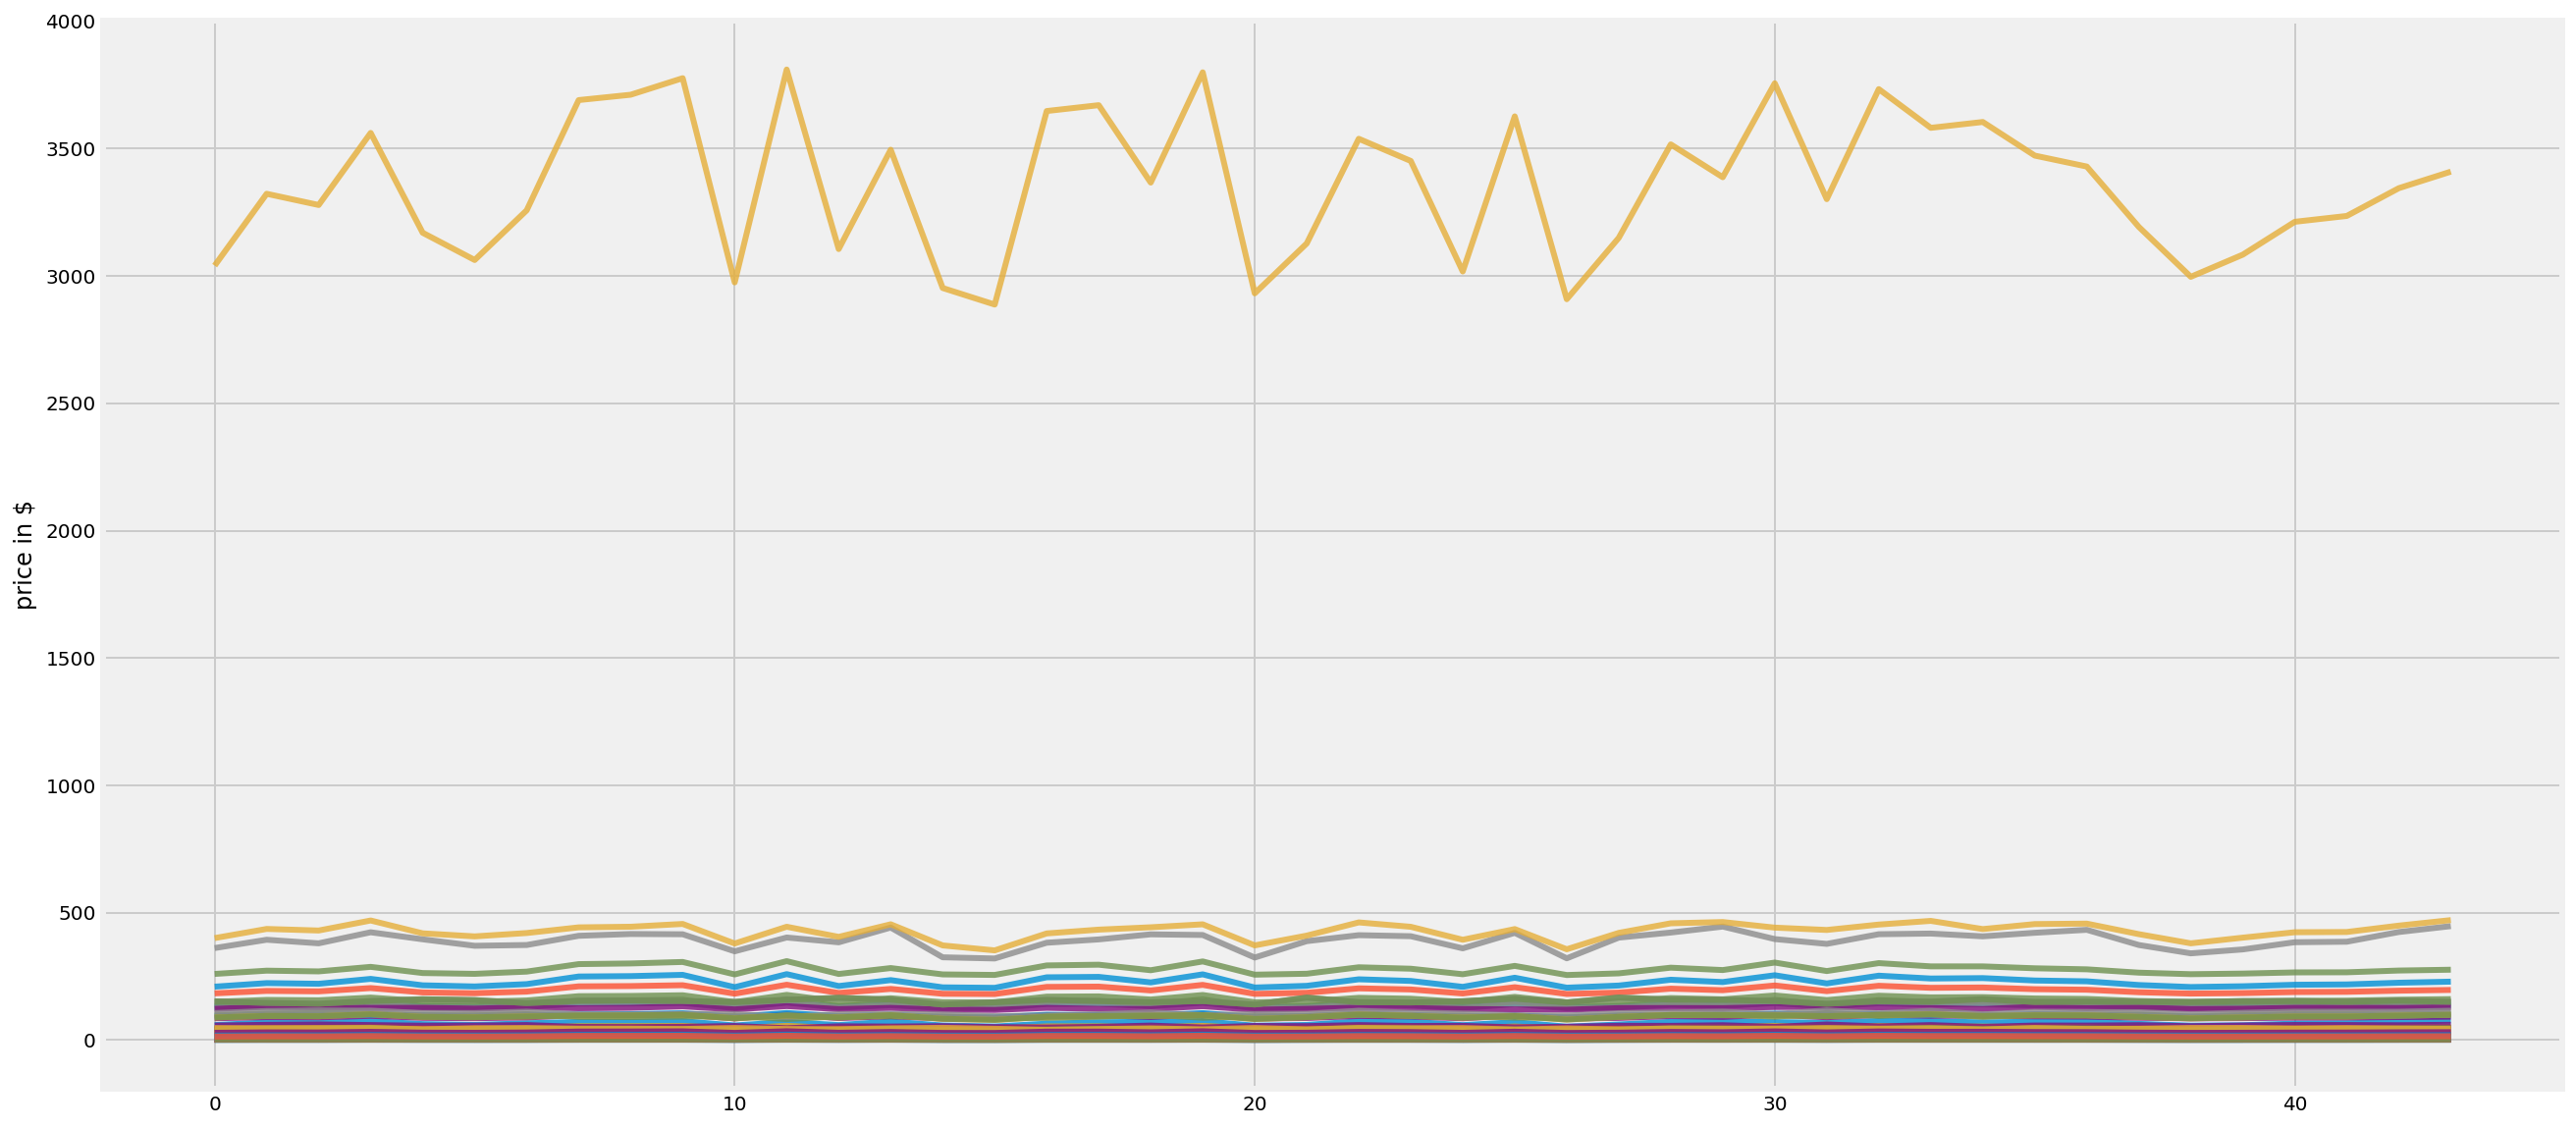

In [16]:
evolved_time_frame(index_portfolio_df.drop("operation_date"))

# me ahorro este paso, ya no es necesario pasarlo a pandas

In [17]:
monthly_data = index_portfolio_df.toPandas()
print("nuestros datos:", monthly_data.shape)

nuestros datos: (44, 214)


In [18]:
spark.catalog.clearCache()

In [19]:
## Lo mismo hacemos, pero para el resto de variables equity,
## seleccionamos la primera columna y lo convertimos a vector, esta columna representa el indice que estamos analizando, 
## 'MXWDU_Index', la idea es medir esta columna con el resto, ya que las demás son acciones que forman parte de ese índice.

investment_universe_month = monthly_data.sort_values('operation_date').drop(['operation_id', "operation_date"], axis = 1)

# nuestros datos
print(investment_universe_month.shape)
investment_universe_month

(44, 212)


,MXWDU_Index,SCOTIAG,AXESCP,BMERGOB,BMRGOB25,VALUEF4,BLKDIA7,BLKGUB1,GBMGUBL,INVEXGU,...,HSBC-80,FINDE1400,ACTIGOB401,AXESMP402,HSBCMP405,INVEXMP407,NAFFP28,PRINFMP410,PRINMAS411,VECTMD414
15,52.860001,2.883770,2.015131,35.178982,31.169769,84.121132,24.680389,1.838127,1.617455,147.277298,...,1.43480,2.497090,4.425289,2.012394,16.062031,1.777677,18.329241,27.668961,16.917130,13.431810
26,52.200001,2.891846,2.016843,35.265209,31.221399,84.256142,24.745430,1.843074,1.620235,147.542206,...,1.45049,2.505682,4.435736,2.014991,16.054190,1.779171,18.346180,27.712021,16.936569,13.463880
20,56.060001,2.900382,2.019683,35.369720,31.323650,84.430229,24.817570,1.848704,1.623486,147.858200,...,1.47719,2.517362,4.448667,2.019527,16.095720,1.783234,18.379021,27.806660,17.012400,13.509610
14,56.810001,2.908540,2.022532,35.466530,31.424021,84.577118,24.884239,1.853805,1.626434,148.146698,...,1.47523,2.522300,4.459921,2.021708,16.124140,1.787010,18.410130,27.884291,17.061760,13.546310
10,57.000000,2.917284,2.025423,35.572048,31.511230,84.739281,24.958860,1.858902,1.629770,148.469604,...,1.50665,2.525776,4.471095,2.023689,16.125910,1.789778,18.440599,27.940790,17.078501,13.583850
38,56.230000,2.925575,2.028237,35.672359,31.613371,84.895119,25.030230,1.864202,1.632949,148.774597,...,1.50891,2.540164,4.483688,2.027372,16.171379,1.793637,18.468620,28.037430,17.156370,13.626800
24,58.349998,2.934595,2.031284,35.776989,31.694250,85.073196,25.107630,1.869680,1.636587,149.117706,...,1.55303,2.550953,4.496802,2.030811,16.197750,1.796955,18.498730,28.125151,17.209530,13.664360
0,58.549999,2.945098,2.035212,35.905201,31.810520,85.282547,25.197010,1.876392,1.640806,149.517105,...,1.56606,2.556591,4.512620,2.034337,16.239920,1.802321,18.541241,28.219740,17.248859,13.712550
5,59.099998,2.954642,2.038592,36.019180,31.910669,85.472832,25.278910,1.882257,1.644658,149.881699,...,1.58047,2.565762,4.524696,2.038403,16.267969,1.805881,18.576799,28.305981,17.294609,13.755130
39,57.970001,2.965716,2.042937,36.151321,32.034592,85.712433,25.374029,1.889264,1.649300,150.318298,...,1.55973,2.574640,4.541207,2.043536,16.306400,1.810993,18.619970,28.418051,17.372351,13.806210


In [20]:
## (t+1 / t)-1
## (precio_hoy / precio_ayer)-1

pct_investment_month = investment_universe_month.pct_change(1)

# nuestros datos
print(pct_investment_month.shape)
pct_investment_month

(44, 212)


,MXWDU_Index,SCOTIAG,AXESCP,BMERGOB,BMRGOB25,VALUEF4,BLKDIA7,BLKGUB1,GBMGUBL,INVEXGU,...,HSBC-80,FINDE1400,ACTIGOB401,AXESMP402,HSBCMP405,INVEXMP407,NAFFP28,PRINFMP410,PRINMAS411,VECTMD414
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,-0.012486,0.002800,0.000850,0.002451,0.001656,0.001605,0.002635,0.002691,0.001719,0.001799,...,0.010935,0.003441,0.002361,0.001291,-0.000488,0.000840,0.000924,0.001556,0.001149,0.002388
20,0.073946,0.002952,0.001408,0.002964,0.003275,0.002066,0.002915,0.003055,0.002007,0.002142,...,0.018408,0.004661,0.002915,0.002251,0.002587,0.002284,0.001790,0.003415,0.004477,0.003397
14,0.013379,0.002813,0.001411,0.002737,0.003204,0.001740,0.002686,0.002759,0.001816,0.001951,...,-0.001327,0.001962,0.002530,0.001080,0.001766,0.002118,0.001693,0.002792,0.002901,0.002717
10,0.003344,0.003006,0.001429,0.002975,0.002775,0.001917,0.002999,0.002749,0.002051,0.002180,...,0.021298,0.001378,0.002505,0.000980,0.000110,0.001549,0.001655,0.002026,0.000981,0.002771
38,-0.013509,0.002842,0.001389,0.002820,0.003241,0.001839,0.002859,0.002851,0.001951,0.002054,...,0.001500,0.005697,0.002816,0.001820,0.002820,0.002156,0.001520,0.003459,0.004560,0.003162
24,0.037702,0.003083,0.001502,0.002933,0.002558,0.002098,0.003092,0.002939,0.002228,0.002306,...,0.029240,0.004247,0.002925,0.001696,0.001631,0.001850,0.001630,0.003129,0.003098,0.002756
0,0.003428,0.003579,0.001934,0.003584,0.003669,0.002461,0.003560,0.003590,0.002578,0.002678,...,0.008390,0.002210,0.003518,0.001736,0.002603,0.002986,0.002298,0.003363,0.002285,0.003527
5,0.009394,0.003241,0.001661,0.003174,0.003148,0.002231,0.003250,0.003126,0.002348,0.002438,...,0.009201,0.003587,0.002676,0.001999,0.001727,0.001975,0.001918,0.003056,0.002652,0.003105
39,-0.019120,0.003748,0.002131,0.003669,0.003883,0.002803,0.003763,0.003723,0.002823,0.002913,...,-0.013123,0.003460,0.003649,0.002518,0.002362,0.002831,0.002324,0.003959,0.004495,0.003713


In [21]:
## el vector de percentage change se convierte a un arreglo numpy de dimensión (147,70)

pct_investment_month_array = np.array(pct_investment_month.drop('MXWDU_Index', axis=1))
#_pct_investment_month_array = np.array(_pct_investment_month)

# nuestros datos
print(pct_investment_month_array.shape)
print(pct_investment_month_array)

(44, 211)
[[       nan        nan        nan ...        nan        nan        nan]
 [0.00280046 0.0008496  0.00245106 ... 0.00155628 0.00114906 0.00238752]
 [0.00295174 0.0014081  0.00296354 ... 0.00341511 0.00447726 0.00339651]
 ...
 [0.00564063 0.00415337 0.0059669  ... 0.00704992 0.00697923 0.00527787]
 [0.0065999  0.00487864 0.00703335 ... 0.00742412 0.00678837 0.00645554]
 [0.00301039 0.00221634 0.00319064 ... 0.00515819 0.0050844  0.00369799]]


In [22]:
pct_benchmark_month_array = np.array(pct_investment_month['MXWDU_Index'])
print(pct_benchmark_month_array.shape)
print(pct_benchmark_month_array)

(44,)
[        nan -0.01248581  0.07394636  0.01337852  0.00334446 -0.01350877
  0.03770226  0.00342761  0.00939366 -0.01912009  0.01035016  0.01024412
  0.0290688   0.02512726  0.01345723  0.01612395  0.02209082 -0.00319633
  0.02733243  0.00401314  0.01880084  0.02150542  0.02019912  0.00515888
  0.05701209 -0.04475061 -0.01497464  0.00404464  0.00472293 -0.01672887
  0.03065242  0.00695764  0.00609679 -0.07433347  0.01585691 -0.08119716
  0.08042387  0.02466819  0.01576803  0.03423425 -0.06070768  0.05164793
  0.00067837 -0.04718008]


In [23]:
## creamos arreglos numpy con dimensiones X+1 = 148, rellenas de ceros, para ser imputados con nuevos vectores

up_month = np.zeros((pct_benchmark_month_array.shape[0]+1, 1))
down_month = np.zeros((pct_benchmark_month_array.shape[0]+1, 1))
up_move = np.zeros((pct_benchmark_month_array.shape[0]+1, pct_investment_month_array.shape[1]))
down_move = np.zeros((pct_benchmark_month_array.shape[0]+1, pct_investment_month_array.shape[1]))

print(up_month.shape)
print(down_month.shape)
print(up_move.shape)
print(down_move.shape)

(45, 1)
(45, 1)
(45, 211)
(45, 211)


In [24]:
## rellenamos las matrices de ceros con valores que aprueben las condiciones, 
## se realiza una comparación dentro de los arreglos de porcentajes de cambio, 
## sí alguno de esos porcentajes es superior a 0, entonces entra a los arreglos 
## de movimientos positivos (incrementos), pero sí alguno es menor que 0, entonces
## el porcentaje se almacena en los arreglos de movimientos negativos (decrementos).

## Básicamente, se separan los porcentajes de cambio en dos matrices: 
## matriz de positivos cuando el porcentaje es > 0 
## matriz de negativos cuando el porcentaje es <= 0

size_benchmark_matrix = pct_benchmark_month_array.shape[0]
for i in range (1, size_benchmark_matrix):
    if pct_benchmark_month_array[i] > 0:
        up_month[i] = pct_benchmark_month_array[i]
        up_move[i] = pct_investment_month_array[i, 0:pct_investment_month_array.shape[1]]
    else:
        down_month[i] = pct_benchmark_month_array[i]
        down_move[i] = pct_investment_month_array[i, 0:pct_investment_month_array.shape[1]]
        
print(up_month.shape)
print(down_month.shape)
print(up_move.shape)
print(down_move.shape)

(45, 1)
(45, 1)
(45, 211)
(45, 211)


In [25]:
## calculamos el ratio de los vectores con matrices 'peor más alto' y 'mejor más alto'

np.seterr(divide='ignore', invalid='ignore')
greater_worse = down_move / down_month
greater_better = (up_move / up_month) * float(-1.0)

print(greater_worse.shape)
print(greater_better.shape)

(45, 211)
(45, 211)


In [26]:
## ambos vectores los convertimos a pandas dataframes, y solo nos quedamos con los vectores que tengan valores != np.nan
## una de las ventajas de los pandas dataframes es que mantienen un ídince único por row, esto lo hace poder separarse, y juntarse
## en cuantos sub-conjuntos se requieran y siempre se podrá mantener un órden.

greater_worse_df = pd.DataFrame(data=greater_worse).dropna()
greater_better_df = pd.DataFrame(data=greater_better).dropna()

print(greater_worse_df.shape)
print(greater_better_df.shape)

(11, 211)
(32, 211)


In [27]:
## calculamos ahora, la mediana acumulada con los pandas dataframes que construimos, 
## con un periodo mínimo (método expanding) de al menos 1 observación dada.

median_down = greater_worse_df.expanding(axis=1).median()
median_up = greater_better_df.expanding(axis=1).median()

print(median_down.shape)
print(median_up.shape)

(11, 211)
(32, 211)


In [28]:
# se transponen ambos pandas df por la columna periodos, columna que almacena números no consecutivos desde 1 hasta 147

down_transpose = median_down.T
up_transpose = median_up.T

print(down_transpose.shape)
print(up_transpose.shape)

(211, 11)
(211, 32)


In [29]:
# se rankean los resultados (top 10) entre las fechas cierre (periodo) y se vuelve a transponer la tabla ranked_down

ranked_down = down_transpose.rank(method='first')
transpose_ranked_down = ranked_down.T

print(ranked_down.shape)
print(transpose_ranked_down.shape)

(211, 11)
(11, 211)


In [30]:
# se rankean los resultados (top 10) entre las fechas cierre (periodo) y se vuelve a transponer la tabla ranked_up

ranked_up = up_transpose.rank(method='first')
transpose_ranked_up = ranked_up.T

print(ranked_up.shape)
print(transpose_ranked_up.shape)

(211, 32)
(32, 211)


In [31]:
## se añade variable 'label' con la idea de que al juntar ambos dataframes se puedan distinguir los 'worse' de los 'better'
## y se unen ambos dataframes con la etiqueta creada, se usó el método 'insert' por lo que no se deberá correr de nuevo, una
## vez ejecutado ya que fallará por duplicidad de columnas.

worse_better_pd = pd.concat([transpose_ranked_up, transpose_ranked_down]).sort_index()
print(worse_better_pd.shape)

(43, 211)


In [32]:
## se crea un índice 'closing_id' para cada registro, éste corre de [1:N+1] 
## con la idea de etiquetar el id del mes de registro de cierre,
## de la misma forma que lo anterior, NO se deberá ejecutar de nuevo; una vez hecho.

worse_better_pd['closing_id'] = range(1, len(worse_better_pd) + 1)
print(worse_better_pd.shape)

(43, 212)


In [33]:
## se transponen ambos dataframes, de antes tener una dimensión (68, 70), es decir; 
## 68 registros i.e. 'Rows' (variables)
## 70 columnas fijas (a menos que sea añadido otro asset desde el csv inicial)

## a tener una dimensión 'transpuesta' (invertída sí querés...) de (70, 68), es decir;
## 70 registros i.e. 'Rows' fijos (a menos que sea añadido otro asset desde el csv inicial)
## 68 columnas (variables)

In [34]:
asset_name_list = index_portfolio_df.drop('operation_id', "operation_date", "MXWDU_Index").columns
print(asset_name_list, '\n')

['SCOTIAG', 'AXESCP', 'BMERGOB', 'BMRGOB25', 'VALUEF4', 'BLKDIA7', 'BLKGUB1', 'GBMGUBL', 'INVEXGU', 'NTEGUB13', 'NTEGUB15', 'PRINFGU', 'ST&ER1X', 'STERGOB', 'SURCETE', 'VECTPRE', 'FONDEO', 'SCOTIA1', 'BMERLIQ28', 'DINBUR1', 'FONSER130', 'GBMF2', 'INBUMAX', 'INVEXCP', 'ACTIREN', 'SUR1E', 'MONEX28', 'BLKDIN45', 'VECTRF48', 'NTEMP+50', 'SBANKCP', 'BMERLIQ52', 'BMERTES', 'BMRGOB254', 'BLKDIA55', 'BLKLIQ/A', 'BLKPLUSA', 'FONSER161', 'PYMES', 'ST&ER1P', 'STER10P', 'SUPER', 'INVEXDX', 'HSBCEMP69', 'VECTRF71', 'SCOTIA2', 'ACTIGOB74', 'AFIRPLU', 'AXESMP76', 'BLK1LIQA', 'HSBCMP83', 'INVEXMP85', 'NTEMP+86', 'PRINFMP88', 'PRINMAS89', 'VECTMD92', 'HSBCEMP93', 'ACTIMED', 'ALTERNA', 'GBMF3', 'GBMM3', 'HSBCCOR', 'NTEDP', 'NTEMP+105', 'SURCORP', 'FINDE1110', 'SBANKMP', 'INVEXMP117', 'DMEDIO', 'PRINFMP119', 'NTEMP+120', 'BONDDIA', 'PRINMAS125', 'AXESMP130', 'GBMGUB', 'SCOTILP', 'INBUREX', 'PRINGLP', 'SUR30E', 'SURBONO', 'AXESLP', 'SCOTLPG', 'SCOTIMB', 'NAFINTR', 'PRINFTR', 'STEREAL', 'SURUDI', 'FT/REAL'

In [35]:
## de pandas dataframes, una vez separados en dos conjuntos ['worse', 'better'],
## creamos por separado dos spark dataframes.

worse_better_df = spark.createDataFrame(worse_better_pd)
worse_better_df.show(5, False)

+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---

In [36]:
mapping = dict(zip((worse_better_df.columns), asset_name_list))
mapped_name_df = worse_better_df.select([col(c).alias(mapping.get(c, c)) for c in worse_better_df.columns])
print(mapped_name_df.shape)
mapped_name_df.show(5, False)

(43, 212)
+-------+------+-------+--------+-------+-------+-------+-------+-------+--------+--------+-------+-------+-------+-------+-------+------+-------+---------+-------+---------+-----+-------+-------+-------+-----+-------+--------+--------+--------+-------+---------+-------+---------+--------+--------+--------+---------+-----+-------+-------+-----+-------+---------+--------+-------+---------+-------+--------+--------+--------+---------+--------+---------+---------+--------+---------+-------+-------+-----+-----+-------+-----+---------+-------+---------+-------+----------+------+----------+---------+-------+----------+---------+------+-------+-------+-------+------+-------+------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+-------+----------+----------+----------+----------+-------+----------+----------+----------+----------+-------+-------+-------+------+-------+------+-------+-------+-------+-------+-------+-------+------+-------+-------+------+

In [37]:
mapped_name_df.coalesce(1).write.mode("overwrite").parquet("data/ophelia/out/engine/RankMedian")

# Finish Rank Median Module

# Start TopAssetRank

In [38]:
worse_better = spark.read.parquet("data/ophelia/out/engine/RankMedian/")
print(worse_better.shape)

(43, 212)


In [39]:
## se crea un generador "shape long format", una lista con iteraciones, esta lista trabajará con dos variables principales,
## 1-. la variable 'equity_index', será la que contenga los 'id' de los activos
## 2-. la variable 'median_down', será la que contenga la mediana acumulada por cada activo.
## Se mantendrá a lo largo de la transformación 1 columna fija; 'closing_id',
## closing_id: variable que indica el mes de cierre y reporte de precio

def panel_format(df, pivot_col, new_columns: list = []):
    first_col = str(new_columns[0])
    second_col = str(new_columns[1])
    piv_col = [pivot_col]
    df_types = df.dtypes
    cols, dtype = zip(*[(c, t) for (c, t) in df_types if c not in piv_col])
    if len(set(dtype)) > 1:
        raise ValueError("Columns not the same data type...")
    generator_explode = explode(array([
        struct(lit(c).alias(first_col), col(c).alias(second_col)) for c in cols
    ])).alias("column_explode")
    column_to_explode = ["column_explode."+first_col, "column_explode."+second_col]
    panel_df = df.select(piv_col + [generator_explode])\
                 .select(piv_col + column_to_explode)
    return panel_df

In [40]:
## se crea nuevo spark-dataframe donde solo se mostrará por partición ['closing_id'] 
## el top 10 mejores meses donde tuvo menos malos que el resto de los registros; ["top_rank"].
new_columns = ["ticker", "rank"]
asset_ranking_df = worse_better.transpose("closing_id", new_columns)
print(asset_ranking_df.shape)
asset_ranking_df.printSchema()
asset_ranking_df.show(10, False)

(9073, 3)
root
 |-- closing_id: long (nullable = true)
 |-- ticker: string (nullable = false)
 |-- rank: double (nullable = true)

+----------+--------+-----+
|closing_id|ticker  |rank |
+----------+--------+-----+
|1         |SCOTIAG |1.0  |
|1         |AXESCP  |209.0|
|1         |BMERGOB |35.0 |
|1         |BMRGOB25|207.0|
|1         |VALUEF4 |211.0|
|1         |BLKDIA7 |208.0|
|1         |BLKGUB1 |36.0 |
|1         |GBMGUBL |206.0|
|1         |INVEXGU |210.0|
|1         |NTEGUB13|205.0|
+----------+--------+-----+
only showing top 10 rows



In [41]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
map_asset_id = dict(zip(asset_name_list, worse_better_df.columns))

In [42]:
from pyspark.sql.functions import col, create_map, lit, to_json, struct
from itertools import chain

mapping_expr = create_map([lit(x) for x in chain(*map_asset_id.items())])

In [43]:
from pyspark.sql.functions import row_number

w = Window.orderBy('closing_id','rank')
asset_rank_10 = asset_ranking_df.where(col("rank") <= 10).orderBy("closing_id", "rank")\
                                                         .select('*', mapping_expr.getItem(col('ticker')).alias('ticker_id'),
                                                                      (row_number().over(w) - 1).alias('row_id'))
asset_rank_10.coalesce(1).write.mode("overwrite").parquet("data/ophelia/out/engine/LongMedianRank")

In [74]:
asset_rank_10.printSchema()
asset_rank_10.show(100, False)

root
 |-- closing_id: long (nullable = true)
 |-- ticker: string (nullable = false)
 |-- rank: double (nullable = true)
 |-- ticker_id: string (nullable = true)
 |-- row_id: integer (nullable = true)

+----------+----------+----+---------+------+
|closing_id|ticker    |rank|ticker_id|row_id|
+----------+----------+----+---------+------+
|1         |SCOTIAG   |1.0 |0        |0     |
|1         |SVIVE20390|2.0 |200      |1     |
|1         |HSBC-80   |3.0 |201      |2     |
|1         |FINDE1400 |4.0 |202      |3     |
|1         |ACTIGOB401|5.0 |203      |4     |
|1         |AXESMP402 |6.0 |204      |5     |
|1         |HSBC-70   |7.0 |199      |6     |
|1         |HSBCMP405 |8.0 |205      |7     |
|1         |SUR2042384|9.0 |198      |8     |
|1         |INVEXMP407|10.0|206      |9     |
|2         |FINDE1400 |1.0 |202      |10    |
|2         |HSBC-80   |2.0 |201      |11    |
|2         |ACTIGOB401|3.0 |203      |12    |
|2         |SVIVE20390|4.0 |200      |13    |
|2         |AXESM

In [45]:
auto_filter_portfolio = asset_rank_10.where(col('row_id') <= 9)\
                                     .select(col('row_id').cast('string'), col('ticker').cast('string'))\
                                     .rdd.map(lambda x: (x[0], x[1])).collectAsMap()
auto_filter_portfolio

{'0': 'SCOTIAG',
 '1': 'SVIVE20390',
 '2': 'HSBC-80',
 '3': 'FINDE1400',
 '4': 'ACTIGOB401',
 '5': 'AXESMP402',
 '6': 'HSBC-70',
 '7': 'HSBCMP405',
 '8': 'SUR2042384',
 '9': 'INVEXMP407'}

# Finish TopAssetRank

# Start TrainPortfolioSimulation

In [46]:
asset_rank_10_pd = pd.read_parquet("data/ophelia/out/engine/LongMedianRank/")
asset_rank_10_pd

,closing_id,ticker,rank,ticker_id,row_id
0,1,SCOTIAG,1.0,0,0
1,1,SVIVE20390,2.0,200,1
2,1,HSBC-80,3.0,201,2
3,1,FINDE1400,4.0,202,3
4,1,ACTIGOB401,5.0,203,4
...,...,...,...,...,...
425,43,SCOTIPC,6.0,109,425
426,43,ACTIVAR,7.0,110,426
427,43,BLKDOLS,8.0,103,427
428,43,BMERIND,9.0,111,428


In [47]:
## lo que se pretende ahora, es obtener una matriz de dimensión (146, 10), es decir, 
## tener en cada row las fechas de cierre [closing_id],
## en cada columna (header) el número de ranking top 10 [top_rank],
## y en cada campo, el id del activo [asset_id].

pandas_df = asset_rank_10_pd.astype({'ticker_id':'int32'}) # le damos el tipo de dato int32 a la columna ticker
newselect = asset_rank_10_pd[["closing_id", "ticker_id"]] # seleccionamos solo estas dos columnas
num_of_assets = 10 # numero de assets que se crearan

indexed = np.zeros((investment_universe_month.shape[0], num_of_assets))

for q in range(1,investment_universe_month.shape[0]):
    selection = newselect.loc[pandas_df["closing_id"]==q]
    newselect_transpose = selection.T
    newpdf = newselect_transpose['ticker_id':].head()
    indexed[q] = newpdf

In [48]:
indexed = indexed[1:investment_universe_month.shape[0]+1]
index_row = indexed.astype(np.int64)
newrow = [0]*num_of_assets #np.zeros((1,num_of_assets))
index_row = np.vstack([index_row,newrow])
portfolio = np.zeros((investment_universe_month.shape[0], num_of_assets))

for r in range(0,investment_universe_month.shape[0]-1):
    s = r+1
    columns = index_row[s]
    portfolio[s] = pct_investment_month_array[s,[columns]]

In [49]:
means = portfolio[1:investment_universe_month.shape[0]-1]
performance = np.dot(portfolio,(1/num_of_assets))
returns = np.zeros((investment_universe_month.shape[0]-1,1))
equalw = np.zeros((investment_universe_month.shape[0]-1,1))
eweights = 1/(pct_investment_month_array.shape[1])
eweighted = np.dot(pct_investment_month_array,eweights)

for x in range (1,investment_universe_month.shape[0]):
    returns[x-1] = sum(performance[x])
    equalw[x-1] = sum(eweighted[x])

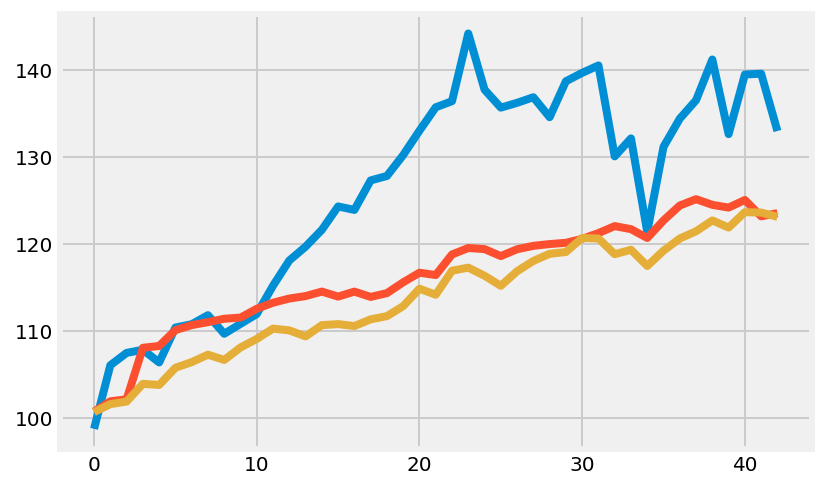

In [50]:
beg = 100
start = 100
commence = 100
bench = pct_benchmark_month_array[1:investment_universe_month.shape[0]]
bmk = np.zeros((investment_universe_month.shape[0],))
port = np.zeros((investment_universe_month.shape[0]-1,))
ew = np.zeros((investment_universe_month.shape[0]-1,))

for i in range (0,investment_universe_month.shape[0]-1):
    bmk[i] = beg*(1+bench[i])
    beg = bmk[i]
    port[i] = start*(1+returns[i])
    start = port[i]
    ew[i] = commence*(1+equalw[i])
    commence = ew[i]

plt.plot(bmk[0:investment_universe_month.shape[0]-1])
plt.plot(port)
plt.plot(ew)

In [51]:
input_assets = index_row[index_row.shape[0]-2]
input_assets1 = pct_investment_month_array[:, input_assets] # dataframe que deberá ser limpiado antes de volver a simular
dataframe = pd.DataFrame(input_assets1)
input_assets1 = dataframe.dropna()
mean_returns = input_assets1.mean()
covar_matrix = input_assets1.cov()
tickers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 12
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(12)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

In [52]:
def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio

        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]

    results_df = pd.DataFrame(results_matrix.T, columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])

    return results_df

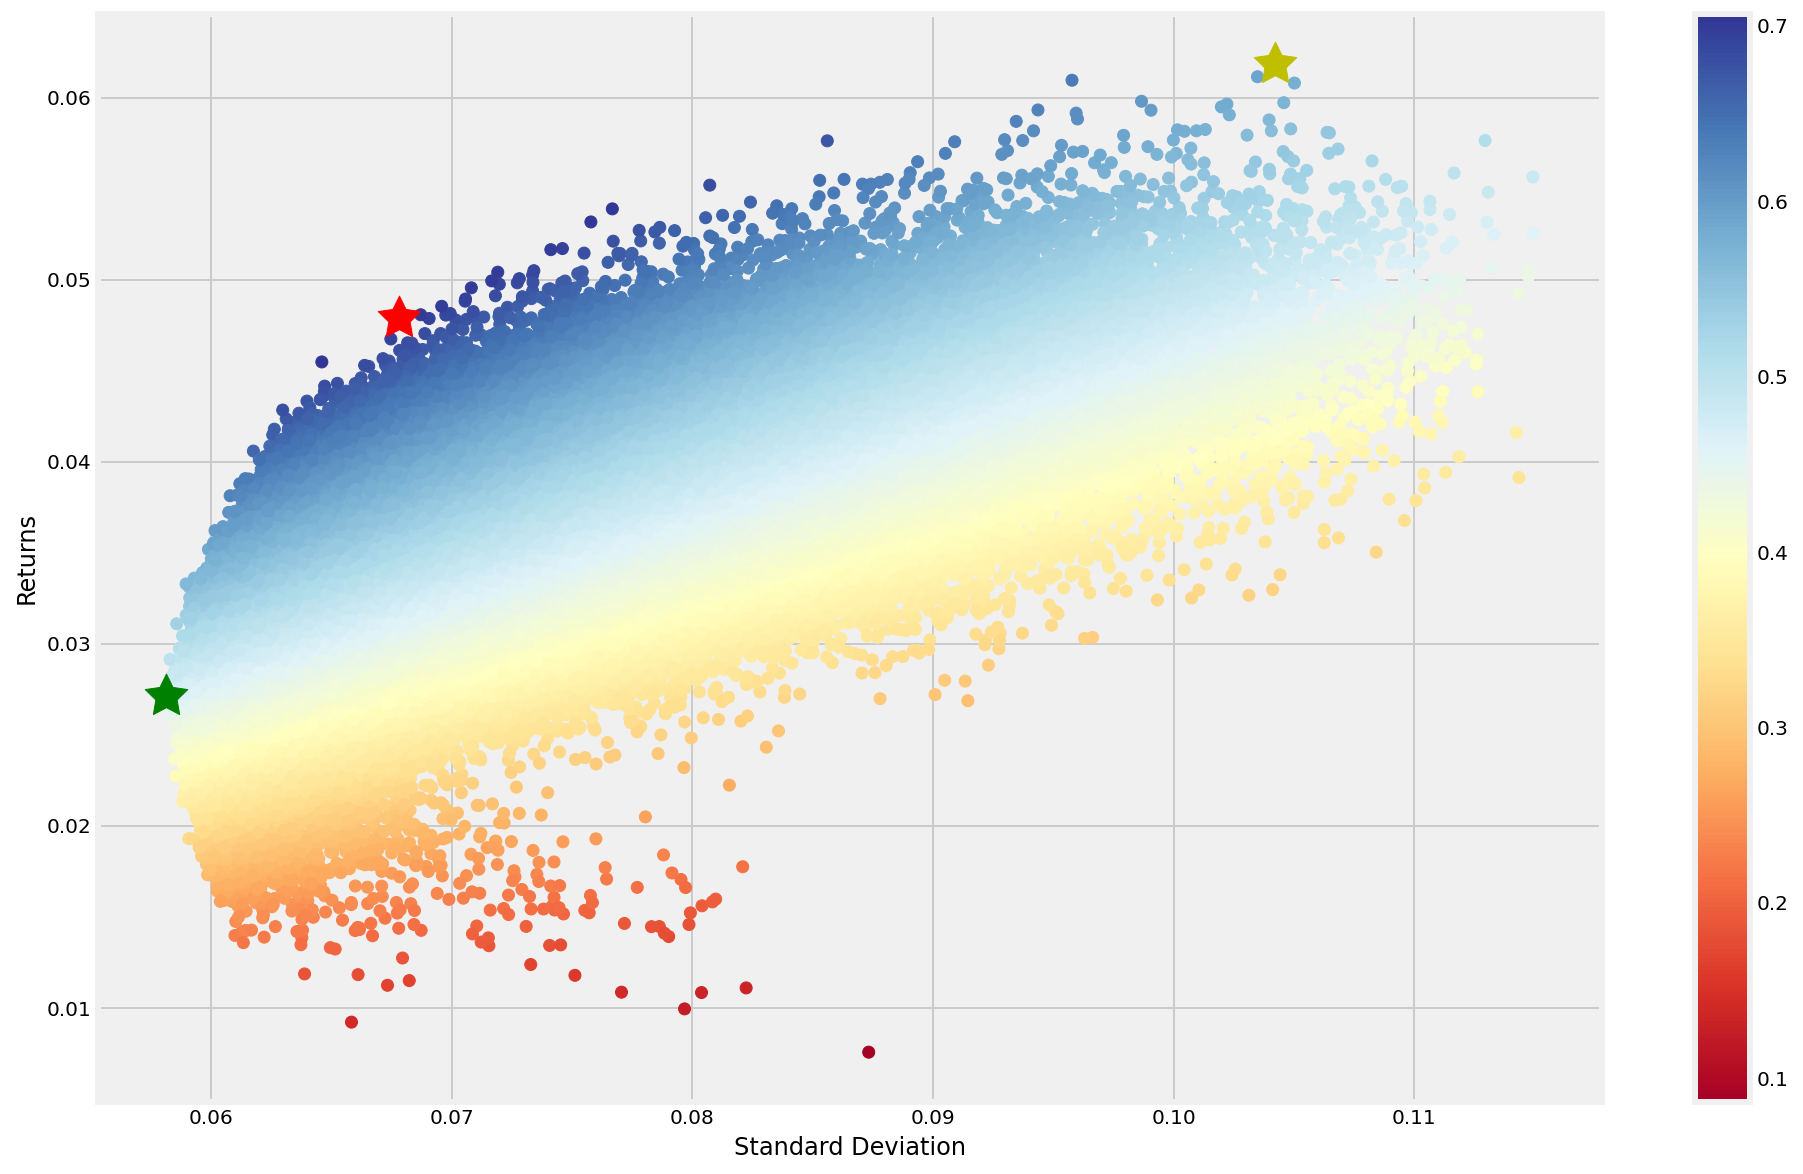

In [53]:
# TODO: revisar la sobrecarga de memoria en los stages marcados

mean_returns = input_assets1.mean()
cov = input_assets1.cov()
num_portfolios = 210000
rf = 0.0

results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]

min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

max_return_port = results_frame.iloc[results_frame['ret'].idxmax()]

plt.subplots(figsize=(15, 10))
plt.scatter(results_frame.stdev, results_frame.ret, c=results_frame.sharpe, cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
plt.scatter(max_sharpe_port['stdev'], max_sharpe_port['ret'], marker=(5,1,0), color='r', s=500)
plt.scatter(min_vol_port['stdev'], min_vol_port['ret'], marker=(5,1,0), color='g', s=500)
plt.scatter(max_return_port['stdev'], max_return_port['ret'], marker=(5,1,0), color='y', s=500)
plt.show()

In [54]:
# nadie usa este metodo
def pd_series_to_dict(pd_series):
    to_python_dict = dict(pd_series)
    return {str(k): float(v) for k, v in to_python_dict.items()}

def persist_metadata_model(pd_data, json_name):
    pd_data.to_json('data/ophelia/out/model/model_info/{}.json'.format(json_name))

# Save train model

In [55]:
results_frame.to_csv('data/ophelia/out/model/tmp/TrainSimulation.csv', encoding='utf-8', index=False)

In [56]:
train_simulation_df = spark.read.csv('data/ophelia/out/model/tmp/TrainSimulation.csv', header=True, inferSchema=True)

In [57]:
results_spark_df = train_simulation_df.select([col(c).alias(auto_filter_portfolio.get(c, c)) for c in train_simulation_df.columns])
results_spark_df.show(5, False)
results_spark_df.describe().show(10, False)
results_spark_df.printSchema()

+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+
|ret                |stdev              |sharpe            |SCOTIAG             |SVIVE20390         |HSBC-80             |FINDE1400           |ACTIGOB401         |AXESMP402            |HSBC-70            |HSBCMP405           |SUR2042384          |INVEXMP407          |
+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+
|0.03276294731988203|0.06466918432427357|0.5066237909480553|0.029655610544278625|0.05873411828140106|0.012050849899143108|0.08932991980269187 |0.16225169055822988|0.1800733058282388   |0.141220

# Save model metadata

In [58]:
%%time
results_to_pandas = results_spark_df.toPandas()
max_sharpe_port_named = results_to_pandas.iloc[results_to_pandas['sharpe'].idxmax()]
min_vol_port_named = results_to_pandas.iloc[results_to_pandas['stdev'].idxmin()]
max_return_port_named = results_to_pandas.iloc[results_to_pandas['ret'].idxmax()]

CPU times: user 1.05 s, sys: 92.7 ms, total: 1.15 s
Wall time: 2.25 s


In [59]:
persist_metadata_model(min_vol_port_named, "minVolatileTrainWeights")

persist_metadata_model(max_sharpe_port_named, "maxSharpeTrainWeights")

persist_metadata_model(max_return_port_named, "maxReturnTrainWeights")

# Finish TrainPortfolioSimulation

# Start EfficientFrontier

In [60]:
import json

def json_read(json_path):
    with open(json_path) as json_file:
        return(json.load(json_file))

In [61]:
json_p = 'data/ophelia/out/model/model_info/minVolatileTrainWeights.json'
min_vol_port_sample = json_read(json_p)
min_vol_port_sample

{'ret': 0.027120364,
 'stdev': 0.0581423806,
 'sharpe': 0.4664474299,
 'SCOTIAG': 0.0217509587,
 'SVIVE20390': 0.0591517347,
 'HSBC-80': 0.2666492688,
 'FINDE1400': 0.1401984824,
 'ACTIGOB401': 0.0045848612,
 'AXESMP402': 0.2209716378,
 'HSBC-70': 0.057655904,
 'HSBCMP405': 0.0564675577,
 'SUR2042384': 0.1656353026,
 'INVEXMP407': 0.0069342921}

In [ ]:
#json_p = 'data/ophelia/out/model/model_info/minVolatileTrainWeights/part-00000-6a7870c6-f591-4274-92c9-d1fa36fd0813-c000.json'
#min_vol_port_sample = json_read(json_p)
#min_vol_port_sample

In [62]:
from pyspark.sql.functions import monotonically_increasing_id, current_date, current_timestamp
from pyspark.ml.feature import QuantileDiscretizer

results_index = results_spark_df.select("*", 
                                        (monotonically_increasing_id() + 1000).alias("portfolio_id"),
                                        current_date().alias("information_date"),
                                        current_timestamp().alias("model_date"))
results_index.show(5, False)

+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+------------+----------------+--------------------------+
|ret                |stdev              |sharpe            |SCOTIAG             |SVIVE20390         |HSBC-80             |FINDE1400           |ACTIGOB401         |AXESMP402            |HSBC-70            |HSBCMP405           |SUR2042384          |INVEXMP407          |portfolio_id|information_date|model_date                |
+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+------------+----------------+--------------------------+
|0.03276294731988203|0

In [63]:
# con x portafolios

filter_min_sharpe_df = results_index.where(col("sharpe") >= min_vol_port_sample['sharpe'])
filter_min_sharpe_df.printSchema()
filter_min_sharpe_df.show(5, False)
filter_min_sharpe_df.describe().show(5, False)

root
 |-- ret: double (nullable = true)
 |-- stdev: double (nullable = true)
 |-- sharpe: double (nullable = true)
 |-- SCOTIAG: double (nullable = true)
 |-- SVIVE20390: double (nullable = true)
 |-- HSBC-80: double (nullable = true)
 |-- FINDE1400: double (nullable = true)
 |-- ACTIGOB401: double (nullable = true)
 |-- AXESMP402: double (nullable = true)
 |-- HSBC-70: double (nullable = true)
 |-- HSBCMP405: double (nullable = true)
 |-- SUR2042384: double (nullable = true)
 |-- INVEXMP407: double (nullable = true)
 |-- portfolio_id: long (nullable = false)
 |-- information_date: date (nullable = false)
 |-- model_date: timestamp (nullable = false)

+--------------------+-------------------+------------------+--------------------+-------------------+--------------------+-------------------+-------------------+---------------------+-------------------+-------------------+--------------------+--------------------+------------+----------------+--------------------------+
|ret           

# for quantile discretization we use two different techniques:
- QuantileDiscretizer from pysspark ml
- Percentile Bucketizer non library used

In [64]:
quantile_discretizer_df = QuantileDiscretizer(
    numBuckets=5,
    inputCol="sharpe",
    outputCol='{}_bucket'.format('risk')).fit(filter_min_sharpe_df).transform(filter_min_sharpe_df).withColumn('risk_bucket', col('risk_bucket') + 1)
print(quantile_discretizer_df.shape)
quantile_discretizer_df.groupBy('risk_bucket').agg(avg("sharpe"), avg("ret"), avg('stdev')).orderBy(col("risk_bucket").desc()).show()
quantile_discretizer_df.show(5, False)
quantile_discretizer_df.printSchema()

(141931, 17)
+-----------+-------------------+--------------------+-------------------+
|risk_bucket|        avg(sharpe)|            avg(ret)|         avg(stdev)|
+-----------+-------------------+--------------------+-------------------+
|        5.0| 0.5809472232660784|0.040716447622851405|0.07010264297752482|
|        4.0| 0.5387994020240862| 0.03830067948632473|0.07108837706956894|
|        3.0| 0.5152916108789315|0.036975764240177456|0.07176023049923287|
|        2.0| 0.4956657277159924| 0.03584353483747898|0.07231530197926407|
|        1.0|0.47654684341786757|  0.0346505365384383|0.07271249711591336|
+-----------+-------------------+--------------------+-------------------+

+--------------------+-------------------+------------------+--------------------+-------------------+--------------------+-------------------+-------------------+---------------------+-------------------+-------------------+--------------------+--------------------+------------+----------------+--------------

In [65]:
# el más rapido
quantile_discretizer_df.coalesce(1).write.mode("overwrite").parquet('data/ophelia/out/model/TrainPortfolio/', partitionBy="information_date")

In [ ]:
#percentile_bucketizer = filter_min_sharpe_df.select("*", 
#                                             when(col("sharpe_centile") < 0.2, lit(5.0)).otherwise(
#                                                 when((col("sharpe_centile") >= 0.2) & (col("sharpe_centile") < 0.4), lit(4.0)).otherwise(
#                                                     when((col("sharpe_centile") >= 0.4) & (col("sharpe_centile") < 0.6), lit(3.0)).otherwise(
#                                                         when((col("sharpe_centile") >= 0.6) & (col("sharpe_centile") < 0.8), lit(2.0)).otherwise(
#                                                             when((col("sharpe_centile") >= 0.8) & (col("sharpe_centile") <= 1.0), lit(1.0)))))).alias("sharpe_bucket"))
#percentile_bucketizer.groupBy("sharpe_bucket").agg(avg("sharpe"), avg("ret")).orderBy("sharpe_bucket").show()
#percentile_bucketizer.show(10, False)
#percentile_bucketizer.printSchema()

In [66]:
pd_restuls_frame = pd.read_parquet("data/ophelia/out/model/TrainPortfolio/")

vol_arr = pd_restuls_frame.stdev
ret_arr = pd_restuls_frame.ret
sharpe_arr = pd_restuls_frame.sharpe

OPTIMIZATION RESULTS

      fun: -0.6403757100512586
     jac: array([-0.05567613,  0.47177534,  0.20866821, -0.05077723, -0.30312617,
       -0.06090794,  0.0551066 ,  0.291264  , -0.00351269,  0.75709391])
 message: 'Optimization terminated successfully'
    nfev: 66
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.2 , 0.05, 0.05, 0.1 , 0.2 , 0.2 , 0.05, 0.05, 0.05, 0.05])


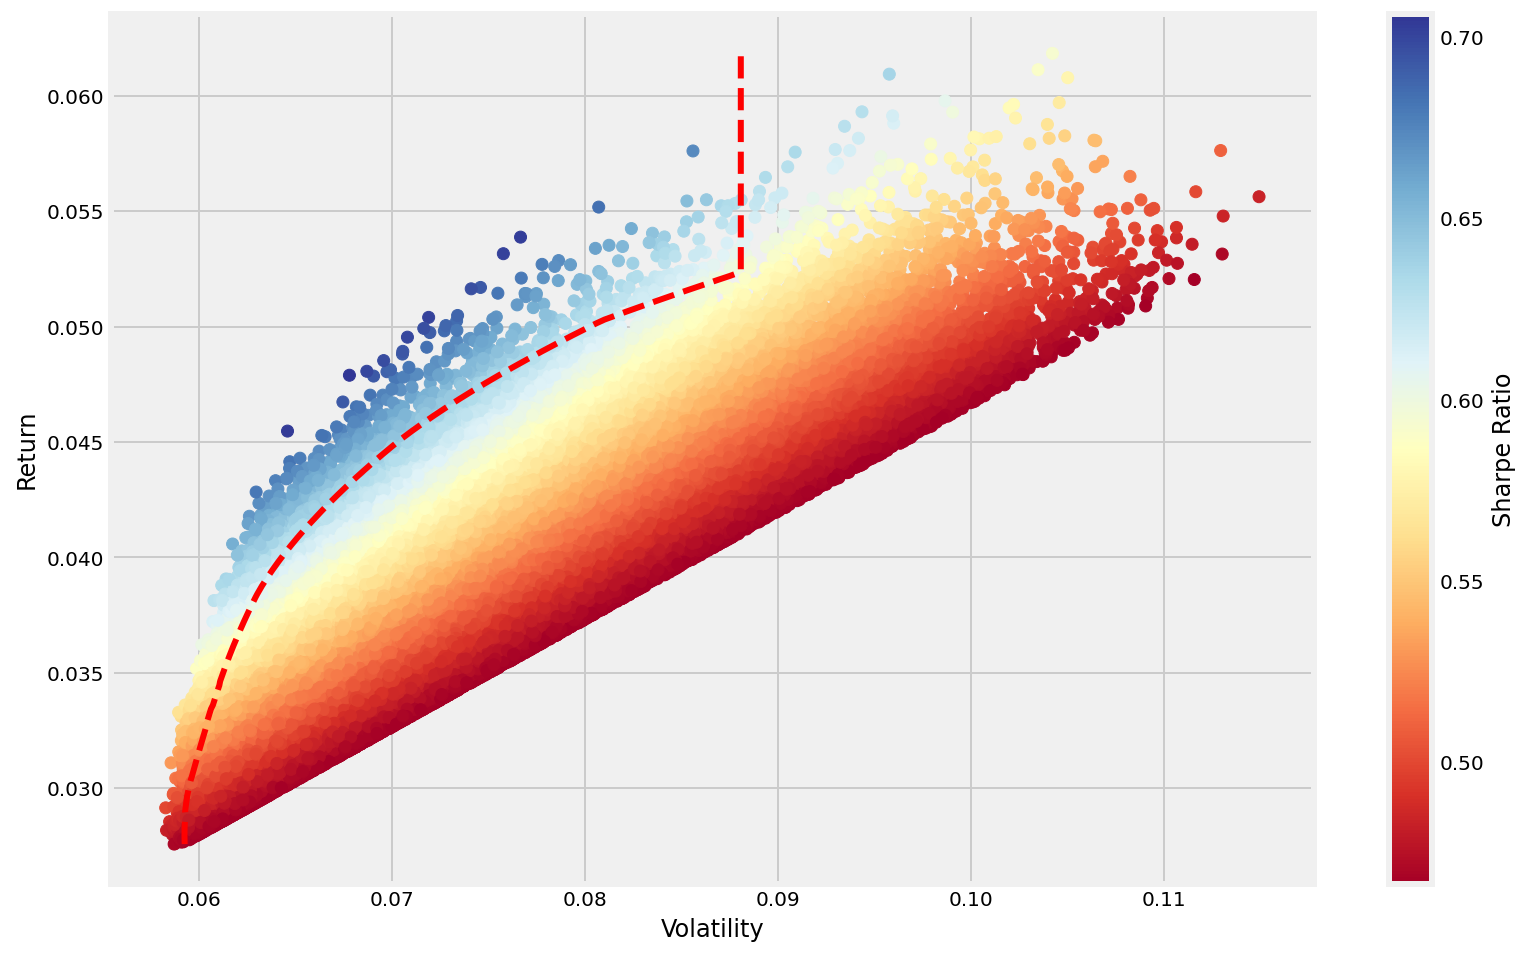

In [72]:
mean_returns = input_assets1.mean()
cov = input_assets1.cov()

def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(mean_returns * weights) * 12
    vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(12)
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
    # the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

cons = ({'type':'eq', 'fun':check_sum})
bound = (.05, .2)
num_assets = 10
bounds = tuple(bound for asset in range(num_assets))
init_guess = [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]
opt_results = sco.minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
print("OPTIMIZATION RESULTS\n\n", opt_results)

get_ret_vol_sr(opt_results.x)

range_vol_min = min(vol_arr)
range_vol_max = max(vol_arr)
range_ret_min = min(ret_arr)
range_ret_max = max(ret_arr)
range_sharpe_min = min(sharpe_arr)
range_sharpe_max = max(sharpe_arr)

frontier_y = np.linspace(range_ret_min, range_ret_max, 200)
frontier_x = []

def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun': check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    result = sco.minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])
    
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='RdYlBu')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x, frontier_y, 'r--', linewidth=3)
# plt.savefig('cover.png')
plt.show()